In [1]:
!pip install 'aif360[LFR]'

     |████████████████████████████████| 175 kB 5.4 MB/s 
     |████████████████████████████████| 564 kB 37.9 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=c21cac46439cd3336ad0d164986568e1c2d7df7c31dc9517378aec2d0486f95d
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-05-13 10:51:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  7.08MB/s    in 0.5s    

2022-05-13 10:51:50 (7.08 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-05-13 10:51:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

**Importing all libraries**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from google.colab import files

from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler  #MinMaxScaler
import numpy as np
from sklearn.linear_model import LogisticRegression

In [5]:
!pip install aequitas==0.42.0
!pip install fairlearn==0.4.6

     |████████████████████████████████| 2.2 MB 5.0 MB/s 
     |████████████████████████████████| 727 kB 53.3 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 456 kB 30.8 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
     |████████████████████████████████| 161 kB 21.0 MB/s 
     |████████████████████████████████| 83 kB 735 kB/s 
     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 80 kB 4.7 MB/s 
     |████████████████████████████████| 2.7 MB 32.9 MB/s 
  Created wheel for Flask-Bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=459de122c163d62f65c1209cfac606f949bd615c2215e3f58071fc99574950b1
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for markdown2: filename=markdown2-2.3.5-py3-none-any.whl size=33327 sha256=2444220617e364333062a2dec670b8b8c0ac4a46a49143136c99ae9c3041

In [6]:
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
#from aif360.algorithms.preprocessing import *
from aif360.algorithms.inprocessing import AdversarialDebiasing


Setting the fairness Matrixs

In [7]:
races = ['White', 'Asian.Pac.Islander', 'Amer.Indian.Eskimo', 'Other', 'Black'] #Set the name of the races

privileged_groups = [{'race': 1}]                                           #set the numbers for the privilage and unprivilage for the race
unprivileged_groups = [{'race': 0}, {'race': 2}, {'race': 3}, {'race': 4}]



dataset_orig = load_preproc_data_adult(['race'])                            #import the data

Managing the dataset into train and test

In [8]:

train, test = dataset_orig.split([0.7], shuffle=True) #split the test and train
print("training data size", train.features.shape)     #find the dimentions of the data
print("dataset feature names", train.feature_names)

#Normalize the dataset, both train and test. This should always be done in any machine learning pipeline!
scale_orig = StandardScaler()                         #create sclaer object
X_train = scale_orig.fit_transform(train.features)    #use the scalerto normalise the data
y_train = train.labels.ravel()                        #Standardise the class labels

X_test = scale_orig.transform(test.features) 
y_test = test.labels.ravel()

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


Functions used in all the tasks

In [9]:
def find_score(predictions, labels):
    
    correct_ans = [] 
    
    for i in labels:
      correct_ans.append(i)     #append the label to the list
    
    lists = zip(predictions, correct_ans)   #put both lists into 1 to make it easier to manage
    
    preds = []
    corrects = []
    
    score = 0
    
    for i in lists:
        if int(round(i[0])) == int(round(i[1])):  #If both elements in the same row equal the same 
            score = score + 1                     #Add 1 to score
        else:
            pass
        
        var = round(i[0])       #round the i to nearest int
        preds.append(int(var))  #update preds
        corrects.append(i[1])
      
    
    accuracy = score/len(labels)      #find the accuracy as a percentage
    print("Model Accuracy", accuracy)
    return accuracy

**Task 1 Finding an 5 Fold Cross validation for Accuracy and Fairness**

In [10]:
print(train.features.shape)
print()
trainVar, trainA = train.split([0.8], shuffle=True)   #spilt training data into 5 fold through the split function

print(trainA.features.shape)

trainVar, trainB = trainVar.split([0.75], shuffle=True)

print(trainB.features.shape)

trainVar, trainC = trainVar.split([0.666666], shuffle=True)

print(trainC.features.shape)

trainD, trainE = trainVar.split([0.5], shuffle=True)

print(trainD.features.shape)
print(trainE.features.shape)

train_cross = [trainA, trainB, trainC, trainD, trainE]  #put all the 5 fold data into a train list
X_train_cross = train_cross     #set the features to the train
Y_train_cross = [0] * 5         #create a list which has 5 spaces to start the lists

for i in range(len(train_cross)):
    Y_train_cross[i] = train_cross[i].labels.ravel() #Find the labels from the train data

scale_orig = StandardScaler()   #setup the scaler object

for i in range(len(train_cross)):
    X_train_cross[i] = scale_orig.fit_transform(train_cross[i].features) #scale the features in 5 fold



(34189, 18)

(6838, 18)
(6838, 18)
(6838, 18)
(6837, 18)
(6838, 18)


In [11]:
from seaborn import matrix
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] #Put all hyperparamters for C in lists
scores = []

solvers = ['newton-cg', 'lbfgs', 'liblinear']     #list of the activation functions

datas = {}

with open('task1crossvalResults.csv', 'w') as csvfile:
    field_names = ['Activation', 'C' , 'crossVal1', 'crossVal2', 'crossVal3', 'crossVal4', 'crossVal5','Accuracy', 'general', 
                   'Par_diff1', 'Par_diff2', 'Par_diff3', 'Par_diff4', 'Par_diff5', 'par_diff_avg',
                   'ep_opp1', 'ep_opp2','ep_opp3', 'ep_opp4', 'ep_opp5', 'ep_opp_avg',
                   'avg_odd1', 'avg_odd2', 'avg_odd3', 'avg_odd4', 'avg_odd5','avg_odds_avg' ,'TPR', 'FPR'] #Name of the columns for the .csv file
    writer = csv.DictWriter(csvfile, fieldnames=field_names)  #write the names of columns in .csv
    writer.writeheader()    #write the headers


    for solv in solvers:  #loop through hyperparemeters
          for c in Cs:
              classifier = LogisticRegression(C=c, solver=solv) #make the logistic regression

              data = {}
              accuracies = []   #create lists for storing the epoch
              cs = []
              activations = []
              par_diff = []
              ep_opp = []
              avg_odds = []
              TPR = []
              FPR = []


              for i in range(len(train_cross)): #loop through to the lenght of train_cross

                  X_test_cross = [] #create lists to store data for the cross validation
                  Y_test_cross = []
                  indexs = []
                  ind = []
                  X = []
                  Y = []

                  for j in range(len(train_cross)): #loop through the cross validation
                      if i == j:                          #If the i == the j index then the X_train[i] is the test
                          X_test_cross = X_train_cross[j] #set the X_train and Y _train
                          Y_test_cross = Y_train_cross[j]
                          ind.append(j)
                      else:
                          indexs.append(j) #all the non test is now in indexs


                  X = np.concatenate([X_train_cross[indexs[0]], X_train_cross[indexs[1]], X_train_cross[indexs[2]]]) #joining all the features together that are not in the test part of the fold
                  Y = np.concatenate([Y_train_cross[indexs[0]], Y_train_cross[indexs[1]], Y_train_cross[indexs[2]]])
                  X = np.concatenate([X, X_train_cross[indexs[3]]]) #the concatenate is 
                  Y = np.concatenate([Y, Y_train_cross[indexs[3]]])

                  LR = classifier.fit(X, Y) #fit all the data that is not in the test

                  predictions = LR.predict(X_test_cross)    #use model to make prediction
                  
                  acc = find_score(predictions, Y_test_cross) #find the accuracy from the test in k-fold

                  train_copy = trainA #As a backup redunacy so the system doesnt crash (Hasnt but there is an else)



                  if i == 0:              #if the iteration is 1 set the copy to the train
                    train_copy = trainA

                  elif i == 1:
                    train_copy = trainB
                  
                  elif i == 2:
                    train_copy = trainC

                  elif i == 3:
                    train_copy = trainD
                  
                  elif i == 4:
                    train_copy = trainE

                  else:
                    print("Error")

                  test_pred = train_copy.copy()               #set the test pred to the train to store features
                  predictions.resize((len(predictions),1))    #resize the predictions
                  test_pred.labels = predictions              #set the labels to the predictions



                  metric = ClassificationMetric(train_copy, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) #create fairness matrix
                  metric_arrs = {}
                  metric_arrs['C'] = c              #store results in the dictionary
                  metric_arrs['Activation'] = solv
                  metric_arrs['Accuracy'] = acc
                  metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
                  metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
                  metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
                  #metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
                  #metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
                  metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
                  metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

                  #print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
                  #print(metric_arrs)
                  #print('\n')


                  accuracies.append(acc)  #store all the data for one epoch
                  cs.append(c)
                  activations.append(solv)
                  par_diff.append((metric.statistical_parity_difference()))
                  ep_opp.append((metric.equal_opportunity_difference()))
                  avg_odds.append((metric.average_odds_difference()))
                  TPR.append((metric.generalized_true_positive_rate()))
                  FPR.append((metric.num_generalized_false_positives()))


              pred_test = LR.predict(X_test)
              test_acc = find_score(pred_test, y_test)
              print("Generalisability --- ", test_acc)

              print("Accuracies: ", accuracies)
              print("Cs", c)
              print("Activation: ", activations)
              print("Par_diff: ", par_diff)
              print("ep_opp: ", ep_opp)
              print("avg_odd: ", avg_odds)
              print("TPR: ", TPR)
              print("FPR: ", FPR)

              acc = sum(accuracies)/len(accuracies) #find the average for all variables for analysis
              par_diff_avg = sum(par_diff)/len(par_diff)
              ep_opp_avg = sum(ep_opp)/len(ep_opp)
              avg_odds_avg = sum(avg_odds)/len(avg_odds)

              writer.writerow({'Activation': solv, 'C': c , 'crossVal1': accuracies[0], 'crossVal2': accuracies[1], 'crossVal3': accuracies[2], 'crossVal4': accuracies[3], 'crossVal5': accuracies[4],'Accuracy': acc, 'general': test_acc, 
                               'Par_diff1': par_diff[0], 'Par_diff2': par_diff[1], 'Par_diff3': par_diff[2], 'Par_diff4': par_diff[3], 'Par_diff5': par_diff[4], 'par_diff_avg': par_diff_avg,
                   'ep_opp1': ep_opp[0], 'ep_opp2': ep_opp[1],'ep_opp3': ep_opp[2], 'ep_opp4': ep_opp[3], 'ep_opp5': ep_opp[4], 'ep_opp_avg': ep_opp_avg,
                   'avg_odd1': avg_odds[0], 'avg_odd2': avg_odds[1], 'avg_odd3': avg_odds[2], 'avg_odd4': avg_odds[3], 'avg_odd5': avg_odds[4],'avg_odds_avg': avg_odds_avg , 'TPR': TPR[0], 'FPR': FPR[0]}) #save the data into .csv

          
files.download('task1crossvalResults.csv')   #save the data into a .csv


Model Accuracy 0.7535829189821586
Model Accuracy 0.7576776835331969
Model Accuracy 0.7581164083065224
Model Accuracy 0.7629077080590903
Model Accuracy 0.7623574144486692
Model Accuracy 0.7648945608407834
Generalisability ---  0.7648945608407834
Accuracies:  [0.7535829189821586, 0.7576776835331969, 0.7581164083065224, 0.7629077080590903, 0.7623574144486692]
Cs 1e-05
Activation:  ['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg']
Par_diff:  [0.0, 0.0, 0.0, 0.0, 0.0]
ep_opp:  [0.0, 0.0, 0.0, 0.0, 0.0]
avg_odd:  [0.0, 0.0, 0.0, 0.0, 0.0]
TPR:  [1.0, 1.0, 1.0, 1.0, 1.0]
FPR:  [0.0, 0.0, 0.0, 0.0, 0.0]
Model Accuracy 0.7535829189821586
Model Accuracy 0.7576776835331969
Model Accuracy 0.7581164083065224
Model Accuracy 0.7629077080590903
Model Accuracy 0.7623574144486692
Model Accuracy 0.7648945608407834
Generalisability ---  0.7648945608407834
Accuracies:  [0.7535829189821586, 0.7576776835331969, 0.7581164083065224, 0.7629077080590903, 0.7623574144486692]
Cs 0.0001
Activation: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plotting the Hyperparamters for TASK1** 

In [12]:
task1_df = pd.read_csv("task1crossvalResults.csv") #read and print the data
task1_df

,Activation,C,crossVal1,crossVal2,crossVal3,crossVal4,crossVal5,Accuracy,general,Par_diff1,...,ep_opp5,ep_opp_avg,avg_odd1,avg_odd2,avg_odd3,avg_odd4,avg_odd5,avg_odds_avg,TPR,FPR
0,newton-cg,0.00001,0.753583,0.757678,0.758116,0.762908,0.762357,0.758928,0.764895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
1,newton-cg,0.00010,0.753583,0.757678,0.758116,0.762908,0.762357,0.758928,0.764895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
2,newton-cg,0.00100,0.807985,0.803451,0.803305,0.803130,0.804621,0.804498,0.802430,-0.108769,...,-0.182808,-0.164747,-0.134690,-0.108274,-0.097215,-0.066973,-0.116084,-0.104647,1.0,0.0
3,newton-cg,0.01000,0.807107,0.803451,0.803598,0.803861,0.804914,0.804586,0.801952,-0.109457,...,-0.195917,-0.154833,-0.132452,-0.093018,-0.083240,-0.065567,-0.125088,-0.099873,1.0,0.0
4,newton-cg,0.10000,0.807107,0.803305,0.803890,0.803861,0.804914,0.804615,0.802293,-0.109457,...,-0.195917,-0.156700,-0.132452,-0.095824,-0.086605,-0.065567,-0.125088,-0.101107,1.0,0.0
5,newton-cg,1.00000,0.807107,0.803305,0.803890,0.803861,0.804914,0.804615,0.802293,-0.109457,...,-0.195917,-0.156700,-0.132452,-0.095824,-0.086605,-0.065567,-0.125088,-0.101107,1.0,0.0
6,newton-cg,10.00000,0.807107,0.803305,0.803890,0.803861,0.804914,0.804615,0.802293,-0.109457,...,-0.195917,-0.156700,-0.132452,-0.095824,-0.086605,-0.065567,-0.125088,-0.101107,1.0,0.0
7,newton-cg,100.00000,0.807107,0.803305,0.803890,0.803861,0.804914,0.804615,0.801952,-0.109457,...,-0.195917,-0.156700,-0.132452,-0.095824,-0.086605,-0.065567,-0.125088,-0.101107,1.0,0.0
8,newton-cg,1000.00000,0.807107,0.803305,0.803890,0.803861,0.804914,0.804615,0.801952,-0.109457,...,-0.195917,-0.156700,-0.132452,-0.095824,-0.086605,-0.065567,-0.125088,-0.101107,1.0,0.0
9,lbfgs,0.00001,0.753583,0.757678,0.758116,0.762908,0.762357,0.758928,0.764895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0


In [26]:
def formula(acc, gen, equ, odds, diff):

    return (acc + gen)/ 1 - (equ + odds + diff) #The algirthm to select the model

df = task1_df

accuacy = df['Accuracy'] #get only the wanted information
general = df['general']
equility = df['ep_opp_avg']
avg_odds = df['avg_odds_avg']
par_diff = df['par_diff_avg']


C = df['C']             #get the paramters of the model
act = df['Activation']


answers = 0

for i in range(len(accuacy)):
    
    ans = formula(accuacy[i], general[i], equility[i], avg_odds[i], par_diff[i]) #loop through varibales and find answer
    
    if ans > answers:             #if it is th best the save the score and variables
        answers = ans
        bestC = C[i]
        bestActivation = act[i]
        
print(bestC, bestActivation, answers) #print the best

0.001 newton-cg 1.97171687673577


**Task 1 Most Accurate Model**

Using the test data which was split from train before the cross validation.

Model Accuracy 0.8027707636661434
C : 0.1 | Activation: lbfgs | Accuracy: 0.8027707636661434
{'stat_par_diff': -0.10360858653908399, 'eq_opp_diff': -0.18414551156873185, 'avg_odds_diff': -0.11698098738262834, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




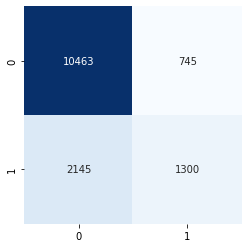

In [13]:
solv = 'lbfgs' #set the paramters for this model
c = 0.1



learner = LogisticRegression(solver=solv, random_state=1, C=c)    #create the classifier
learner.fit(X_train,y_train)                                      #fit the classifier
predictions = learner.predict(X_test)                             #make predictions


conclude = zip(predictions, y_test)                               #Join both  lists together

score = 0                                                         

correct_ans = []

for i in y_test:
  correct_ans.append(i)             #normalise the correct answer by putting into a normal python list

lists = zip(predictions, correct_ans)   #zip the predictions and correct answer

preds = []
corrects = []

score = 0

for i in lists:                   #loop through to see if the prediction is correct
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1         #if correct add one to score
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var)) #round the predictions
    corrects.append(i[1])
  

accuracy = score/len(y_test)      #Workout the score
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)        #make the matrix using sckit learn
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False) #use sea born to make it look good

test_pred = test.copy() 
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 1 Most Fair Model**

Model Accuracy 0.7648945608407834
C : 0.0001 | Activation: newton-cg | Accuracy: 0.7648945608407834
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




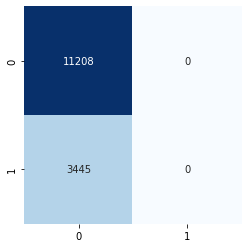

In [14]:


solv = 'newton-cg'
c = 0.0001

learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 3 Select the model (5)**

Model Accuracy 0.8027707636661434
C : 0.01 | Activation: liblinear | Accuracy: 0.8027707636661434
{'stat_par_diff': -0.10360858653908399, 'eq_opp_diff': -0.18414551156873185, 'avg_odds_diff': -0.11698098738262834, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




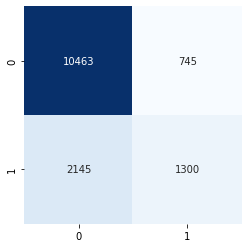

In [24]:
solv = 'liblinear'
c = 0.01

learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 2 Reweighting and applying 5 Fold Cross Validation**

In [15]:


RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)        #create the weights for the bias



train_fair = RW.fit_transform(train)            #find the rewrights for the whole train and tests datasets
test_fair = RW.fit_transform(test)
trainA_fair = RW.fit_transform(trainA.copy())   #Reweight all the 5 fold train and tests
trainB_fair = RW.fit_transform(trainB.copy())
trainC_fair = RW.fit_transform(trainC.copy())
trainD_fair = RW.fit_transform(trainD.copy())
trainE_fair = RW.fit_transform(trainE.copy())


train_weights = [trainA_fair.instance_weights, trainB_fair.instance_weights, trainC_fair.instance_weights, trainD_fair.instance_weights, trainE_fair.instance_weights] #Put the weights into the lists

print("subgroup weights", np.unique(trainA_fair.instance_weights), np.unique(trainB_fair.instance_weights), np.unique(trainC_fair.instance_weights), np.unique(trainD_fair.instance_weights), np.unique(trainE_fair.instance_weights))
train_cross_fair = [trainA_fair, trainB_fair, trainC_fair, trainD_fair, trainE_fair] #put all fair data into the into one list to make it easy to access

X_train_cross_fair = train_cross_fair #set the fair list
Y_train_cross_fair = [0] * 5

scale_orig = StandardScaler()   #setup the scaler object

for i in range(len(train_cross_fair)):
    Y_train_cross_fair[i] = train_cross_fair[i].labels.ravel()  #set the y_train labels

for i in range(len(train_cross)):
    X_train_cross_fair[i] = scale_orig.fit_transform(train_cross_fair[i].features) #scale both features and labels

subgroup weights [0.89225677 0.94194657 1.02056758 1.58549938] [0.89584244 0.94105597 1.02044191 1.57118663] [0.89468241 0.93911547 1.02112205 1.58464763] [0.91383276 0.95097279 1.0162828  1.43556491] [0.90541708 0.94798902 1.01739999 1.50402742]


**Task 2 Reweighting**

In [16]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)        #create the weights for the bias



train_fair = RW.fit_transform(train)            #find the rewrights for the whole train and tests datasets
test_fair = RW.fit_transform(test)
trainA_fair = RW.fit_transform(trainA.copy())   #Reweight all the 5 fold train and tests
trainB_fair = RW.fit_transform(trainB.copy())
trainC_fair = RW.fit_transform(trainC.copy())
trainD_fair = RW.fit_transform(trainD.copy())
trainE_fair = RW.fit_transform(trainE.copy())


train_weights = [trainA_fair.instance_weights, trainB_fair.instance_weights, trainC_fair.instance_weights, trainD_fair.instance_weights, trainE_fair.instance_weights] #Put the weights into the lists

print("subgroup weights", np.unique(trainA_fair.instance_weights), np.unique(trainB_fair.instance_weights), np.unique(trainC_fair.instance_weights), np.unique(trainD_fair.instance_weights), np.unique(trainE_fair.instance_weights))
train_cross_fair = [trainA_fair, trainB_fair, trainC_fair, trainD_fair, trainE_fair] #put all fair data into the into one list to make it easy to access

X_train_cross_fair = train_cross_fair #set the fair list
Y_train_cross_fair = [0] * 5

scale_orig = StandardScaler()   #setup the scaler object

for i in range(len(train_cross_fair)):
    Y_train_cross_fair[i] = train_cross_fair[i].labels.ravel()  #set the y_train labels

for i in range(len(train_cross)):
    X_train_cross_fair[i] = scale_orig.fit_transform(train_cross_fair[i].features) #scale both features and labels

subgroup weights [0.89225677 0.94194657 1.02056758 1.58549938] [0.89584244 0.94105597 1.02044191 1.57118663] [0.89468241 0.93911547 1.02112205 1.58464763] [0.91383276 0.95097279 1.0162828  1.43556491] [0.90541708 0.94798902 1.01739999 1.50402742]


In [17]:
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]    #set the hyperparameters
scores = []

solvers = ['newton-cg', 'lbfgs', 'liblinear']       #set the actionation functions

with open('task2crossvalResults.csv', 'w') as csvfile:
    field_names = ['Activation', 'C' , 'crossVal1', 'crossVal2', 'crossVal3', 'crossVal4', 'crossVal5','Accuracy', 'general',
                   'Par_diff1', 'Par_diff2', 'Par_diff3', 'Par_diff4', 'Par_diff5', 'par_diff_avg',
                   'ep_opp1', 'ep_opp2','ep_opp3', 'ep_opp4', 'ep_opp5', 'ep_opp_avg',
                   'avg_odd1', 'avg_odd2', 'avg_odd3', 'avg_odd4', 'avg_odd5','avg_odds_avg' ,'TPR', 'FPR'] #set the field names for the .csv
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()



    for solv in solvers: #loop through the solves

          for c in Cs:   #loop through c

              data = {}
              accuracies = [] #set the inital lists
              cs = []
              activations = []
              par_diff = []
              ep_opp = []
              avg_odds = []
              TPR = []
              FPR = []

              classifier = LogisticRegression(C=c, solver=solv) #create the classifiers

              for i in range(len(train_cross)): #loop through the cross val

                  X_test_cross_fair = [] #reset the epoch lists
                  Y_test_cross_fair = []
                  indexs = []
                  ind = []
                  X = []
                  Y = []

                  for j in range(len(train_cross)): #loop through
                      if i == j:
                          X_test_cross_fair = X_train_cross_fair[j] #if the i and j are the same this index of training is the testing
                          Y_test_cross_fair = Y_train_cross_fair[j]
                          ind.append(j)
                      else:
                          indexs.append(j)


                  X = np.concatenate([X_train_cross_fair[indexs[0]], X_train_cross_fair[indexs[1]], X_train_cross_fair[indexs[2]]]) #join all the training and not test
                  Y = np.concatenate([Y_train_cross_fair[indexs[0]], Y_train_cross_fair[indexs[1]], Y_train_cross_fair[indexs[2]]])
                  X = np.concatenate([X, X_train_cross_fair[indexs[3]]])
                  Y = np.concatenate([Y, Y_train_cross_fair[indexs[3]]])
                  bias_weights = np.concatenate([train_weights[indexs[0]], train_weights[indexs[1]], train_weights[indexs[2]]])
                  bias_weights = np.concatenate([bias_weights, train_weights[indexs[3]]])


                  #LR = classifier.fit(X, Y, sample_weight=train_cross_fair_weight.instance_weights) #,sample_weight=train.instance_weights fit all the data that is not in the test

                  LR = classifier.fit(X, Y, sample_weight=bias_weights)   #Fit the data the biased X and Y



                  predictions = LR.predict(X_test_cross_fair) #find the predictions from model
                  
                  acc = find_score(predictions, Y_test_cross_fair) #find the accuracy

                  #train_copy = trainA

                  #Set the traincopy to the train index data
                  if i == 0:
                    train_copy = trainA_fair

                  elif i == 1:
                    train_copy = trainB_fair
                  
                  elif i == 2:
                    train_copy = trainC_fair

                  elif i == 3:
                    train_copy = trainD_fair
                  
                  elif i == 4:
                    train_copy = trainE_fair

                  else:
                    print("Error")

                  test_pred = train_copy.copy()             #create the same
                  predictions.resize((len(predictions),1))  #resize prediction
                  test_pred.labels = predictions            #set the labels to the 

                  metric = ClassificationMetric(train_copy, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
                  metric_arrs = {}
                  metric_arrs['stat_par_diff']=(metric.statistical_parity_difference()) #add all the data into the matrix
                  metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
                  metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
                  #metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
                  #metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
                  metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
                  metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

                  print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
                  print(metric_arrs)
                  print('\n')


                  accuracies.append(acc) #store all the data from the epoch
                  cs.append(c)
                  activations.append(solv)
                  par_diff.append((metric.statistical_parity_difference()))
                  ep_opp.append((metric.equal_opportunity_difference()))
                  avg_odds.append((metric.average_odds_difference()))
                  TPR.append((metric.generalized_true_positive_rate()))
                  FPR.append((metric.num_generalized_false_positives()))


              print("Accuracies: ", accuracies)
              print("Cs", c)
              print("Activation: ", activations)
              print("Par_diff: ", par_diff)
              print("ep_opp: ", ep_opp)
              print("avg_odd: ", avg_odds)
              print("TPR: ", TPR)
              print("FPR: ", FPR)

              pred_test = LR.predict(X_test)
              test_acc = find_score(pred_test, y_test)
              print("Generalisability --- ", test_acc)

              acc = sum(accuracies)/len(accuracies)       #find the averages within the data
              par_diff_avg = sum(par_diff)/len(par_diff)
              ep_opp_avg = sum(ep_opp)/len(ep_opp)
              avg_odds_avg = sum(avg_odds)/len(avg_odds)

              writer.writerow({'Activation': solv, 'C': c , 'crossVal1': accuracies[0], 'crossVal2': accuracies[1], 'crossVal3': accuracies[2], 'crossVal4': accuracies[3], 'crossVal5': accuracies[4],'Accuracy': acc, 'general': test_acc,
                               'Par_diff1': par_diff[0], 'Par_diff2': par_diff[1], 'Par_diff3': par_diff[2], 'Par_diff4': par_diff[3], 'Par_diff5': par_diff[4], 'par_diff_avg': par_diff_avg,
                   'ep_opp1': ep_opp[0], 'ep_opp2': ep_opp[1],'ep_opp3': ep_opp[2], 'ep_opp4': ep_opp[3], 'ep_opp5': ep_opp[4], 'ep_opp_avg': ep_opp_avg,
                   'avg_odd1': avg_odds[0], 'avg_odd2': avg_odds[1], 'avg_odd3': avg_odds[2], 'avg_odd4': avg_odds[3], 'avg_odd5': avg_odds[4],'avg_odds_avg': avg_odds_avg , 'TPR': TPR[0], 'FPR': FPR[0]}) #write the data in the .csv

          
files.download('task2crossvalResults.csv')   

Model Accuracy 0.7535829189821586
C : 1e-05 | Activation: newton-cg | Accuracy: 0.7535829189821586
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.7576776835331969
C : 1e-05 | Activation: newton-cg | Accuracy: 0.7576776835331969
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.7581164083065224
C : 1e-05 | Activation: newton-cg | Accuracy: 0.7581164083065224
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.7629077080590903
C : 1e-05 | Activation: newton-cg | Accuracy: 0.7629077080590903
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.7623574144486692
C : 1e-05 | Activation: newton-cg | Accuracy: 0.7623574144486692
{'stat_par_diff':

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plotting**

Plotting the hyper parameters

In [18]:
task2_df = pd.read_csv("task2crossvalResults.csv")
task2_df

,Activation,C,crossVal1,crossVal2,crossVal3,crossVal4,crossVal5,Accuracy,general,Par_diff1,...,ep_opp5,ep_opp_avg,avg_odd1,avg_odd2,avg_odd3,avg_odd4,avg_odd5,avg_odds_avg,TPR,FPR
0,newton-cg,0.00001,0.753583,0.757678,0.758116,0.762908,0.762357,0.758928,0.764895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
1,newton-cg,0.00010,0.753583,0.757678,0.758116,0.762908,0.762357,0.758928,0.764895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
2,newton-cg,0.00100,0.807839,0.802574,0.802135,0.802399,0.804767,0.803943,0.802157,-0.018713,...,0.001402,-0.008720,-0.028925,0.002048,-0.020729,0.005429,-0.007312,-0.009898,1.0,0.0
3,newton-cg,0.01000,0.806815,0.803013,0.801550,0.802838,0.804475,0.803738,0.801884,-0.012970,...,0.007981,0.002449,-0.023560,0.015540,-0.010854,0.008961,-0.002171,-0.002417,1.0,0.0
4,newton-cg,0.10000,0.806815,0.803013,0.801404,0.802252,0.803744,0.803446,0.801884,-0.012970,...,0.002550,0.001363,-0.023560,0.015540,-0.010277,0.011373,-0.006363,-0.002657,1.0,0.0
5,newton-cg,1.00000,0.806815,0.803013,0.801111,0.802252,0.803744,0.803387,0.801406,-0.012970,...,0.002550,0.002645,-0.023560,0.015540,-0.005340,0.011373,-0.006363,-0.001670,1.0,0.0
6,newton-cg,10.00000,0.806815,0.803013,0.801404,0.802838,0.804036,0.803621,0.801406,-0.012970,...,-0.002202,0.000412,-0.023560,0.015540,-0.010277,0.008961,-0.009307,-0.003729,1.0,0.0
7,newton-cg,100.00000,0.806815,0.803013,0.801404,0.802838,0.804036,0.803621,0.801406,-0.012970,...,-0.002202,0.000412,-0.023560,0.015540,-0.010277,0.008961,-0.009307,-0.003729,1.0,0.0
8,newton-cg,1000.00000,0.806815,0.803013,0.801404,0.802838,0.804036,0.803621,0.801406,-0.012970,...,-0.002202,0.000412,-0.023560,0.015540,-0.010277,0.008961,-0.009307,-0.003729,1.0,0.0
9,lbfgs,0.00001,0.753583,0.757678,0.758116,0.762908,0.762357,0.758928,0.764895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0


**Task 2 Reweighted Fair Model**

Model Accuracy 0.7648945608407834
C : 0.001 | Activation: newton-cg | Accuracy: 0.7648945608407834
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




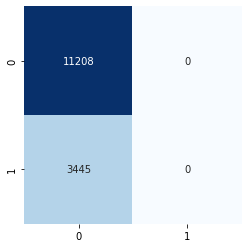

In [19]:
solv = 'newton-cg'
c = 0.001


learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train ,sample_weight=train_fair.instance_weights)
predictions = learner.predict(test_fair.features, )

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 2 Reweighted Accuracy Model**

Model Accuracy 0.8018835733296936
C : 1.0 | Activation: lbfgs | Accuracy: 0.8018835733296936
{'stat_par_diff': -0.05506828011784737, 'eq_opp_diff': -0.02923672575722991, 'avg_odds_diff': -0.024319104585000455, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




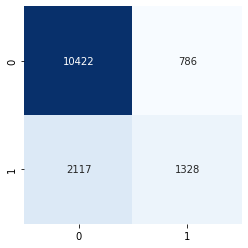

In [20]:



solv = 'lbfgs'
c = 1.0

learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train ,sample_weight=train_fair.instance_weights)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 3 (EXTRA) Fairness Model 6**

In [25]:
def formula(acc, gen, equ, odds, diff):

    return (acc + gen)/ 1 - (equ + odds + diff) #The algirthm to select the model

df = task2_df

accuacy = df['Accuracy'] #get only the wanted information
general = df['general']
equility = df['ep_opp_avg']
avg_odds = df['avg_odds_avg']
par_diff = df['par_diff_avg']


C = df['C']             #get the paramters of the model
act = df['Activation']


answers = 0

for i in range(len(accuacy)):
    
    ans = formula(accuacy[i], general[i], equility[i], avg_odds[i], par_diff[i]) #loop through varibales and find answer
    
    if ans > answers:             #if it is th best the save the score and variables
        answers = ans
        bestC = C[i]
        bestActivation = act[i]
        
print(bestC, bestActivation, answers) #print the best

0.001 newton-cg 1.635320973570155


Model Accuracy 0.8021565549716781
C : 0.001 | Activation: newton-cg | Accuracy: 0.8021565549716781
{'stat_par_diff': -0.06072865747633795, 'eq_opp_diff': -0.04252576230208044, 'avg_odds_diff': -0.033162633302725335, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




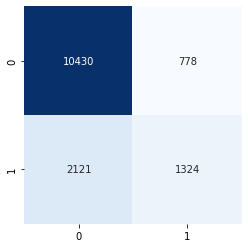

In [23]:
solv = 'newton-cg'
c = 0.001

learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train ,sample_weight=train_fair.instance_weights)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Future work**

In [21]:

import tensorflow as tf


privileged_groups = [{'race': 1}]                                           #set the numbers for the privilage and unprivilage for the race
unprivileged_groups = [{'race': 0}]

sess = tf.compat.v1.Session()



tf.compat.v1.disable_eager_execution()

learner = LogisticRegression(solver='newton-cg', random_state=1, C=0.01)


plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

lis = np.arange(0.0, 1.0, 0.1)

accur = []



sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess,
                          adversary_loss_weight = 0.1)

debiased_model = plain_model.fit(train)

preds = debiased_model.predict(test)

predictionsAAAAA = preds.labels

for i in y_test:
  correct_ans.append(i)

lists = zip(predictionsAAAAA, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0][0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0][0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

accur.append(accuracy)
sess.close()

print(accur)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.752920
epoch 0; iter: 200; batch classifier loss: 0.353102
epoch 1; iter: 0; batch classifier loss: 0.452746
epoch 1; iter: 200; batch classifier loss: 0.352679
epoch 2; iter: 0; batch classifier loss: 0.407403
epoch 2; iter: 200; batch classifier loss: 0.504181
epoch 3; iter: 0; batch classifier loss: 0.380855
epoch 3; iter: 200; batch classifier loss: 0.405097
epoch 4; iter: 0; batch classifier loss: 0.508605
epoch 4; iter: 200; batch classifier loss: 0.476077
epoch 5; iter: 0; batch classifier loss: 0.327546
epoch 5; iter: 200; batch classifier loss: 0.430850
epoch 6; iter: 0; batch classifier loss: 0.471416
epoch 6; iter: 200; batch classifier loss: 0.414595
epoch 7; iter: 0; batch classifier loss: 0.418324
epoch 7; iter: 200; batch classifier loss: 0.385639
epoch 8; iter: 0; batch classifier loss: 0.428684
epoch 8; iter: 200;

Model Accuracy 0.8019518187401897
C : 1.0 | Activation: lbfgs | Accuracy: 0.8019518187401897
{'stat_par_diff': -0.05506828011784737, 'eq_opp_diff': -0.02923672575722991, 'avg_odds_diff': -0.024319104585000455, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




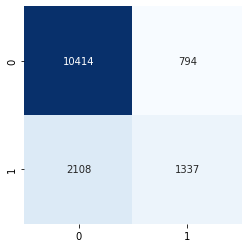

In [22]:
for i in y_test:
  correct_ans.append(i)

lists = zip(predictionsAAAAA, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0][0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0][0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy() 
predictions.resize((len(predictionsAAAAA),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')